Import libraries

In [1]:
from mlxtend.preprocessing import TransactionEncoder
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, association_rules

Load data

In [2]:
fruit_2022 = pd.read_csv("FruitPrices2022.csv")
fruit_2020 = pd.read_csv("FruitPrices2020.csv")
veg_2020 = pd.read_csv("VegetablePrices2020.csv")
veg_2022 = pd.read_csv("VegetablePrices2022.csv")

veg_2022["Name"] = veg_2022["Vegetable"]
veg_2022["Category"] = "Vegetable"
veg_2022["Year"] = 2022

fruit_2022["Name"] = fruit_2022["Fruit"]
fruit_2022["Category"] = "Fruit"
fruit_2022["Year"] = 2022

veg_2020["Name"] = veg_2020["Vegetable"]
veg_2020["Category"] = "Vegetable"
veg_2020["Year"] = 2020

fruit_2020["Name"] = fruit_2020["Fruit"]
fruit_2020["Category"] = "Fruit"
fruit_2020["Year"] = 2020


combine and organize

In [3]:
combined = pd.concat([veg_2022, fruit_2022, veg_2020, fruit_2020], ignore_index = True)
organized = combined.sort_values(by = ["Category", "Name", "Form"])

load GDP data and merge

In [4]:
gdp = pd.read_csv("GDP.csv", header=0)

# Fix column names by converting float years to int strings
gdp.columns = [str(int(col)) if isinstance(col, float) else col for col in gdp.columns]
gdp.columns = gdp.columns.str.strip()  # clean extra whitespace
print(gdp.columns.tolist())


['Country Name', 'Country Code', 'Indicator Name', 'Indicator Code', '1960', '1961', '1962', '1963', '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971', '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979', '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '2023']


In [5]:
gdp_us = gdp[gdp["Country Name"] == "United States"][["2020", "2022"]]

gdp_manual = pd.DataFrame({
    "Year": [2020, 2022],
    "GDP": gdp_us.iloc[0].astype(float).values
})

combined_with_gdp = organized.merge(gdp_manual, on="Year", how="left")


filter by year

In [6]:
data_2020 = combined_with_gdp[combined_with_gdp["Year"] == 2020]
data_2022 = combined_with_gdp[combined_with_gdp["Year"] == 2022]

plot

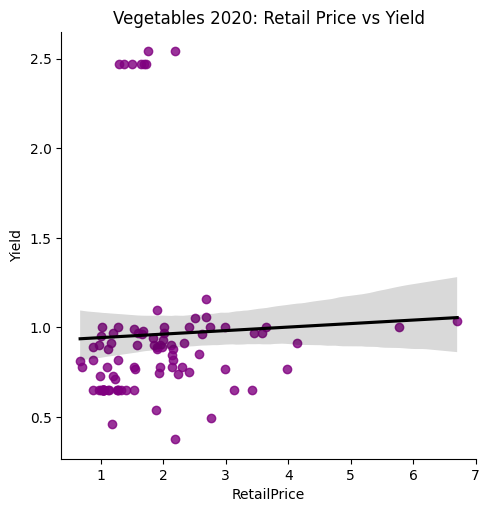

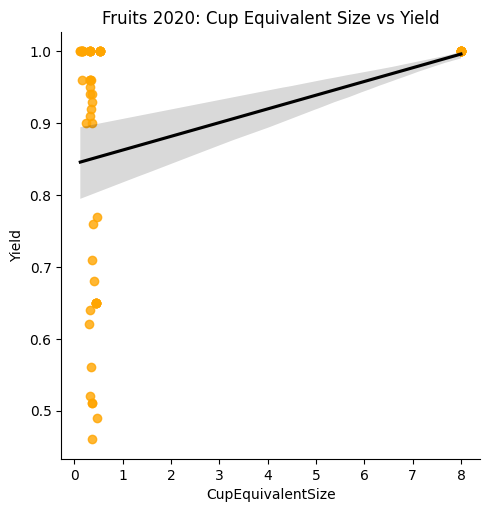

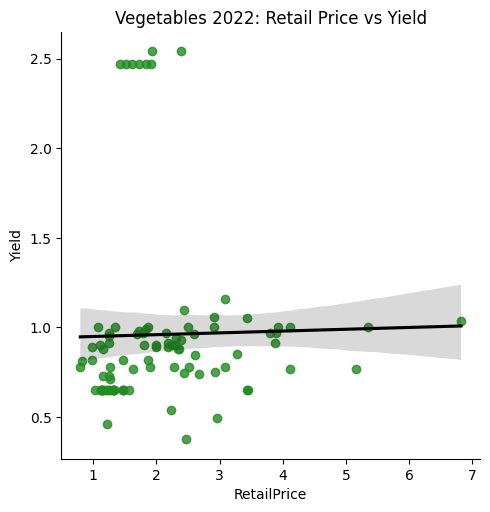

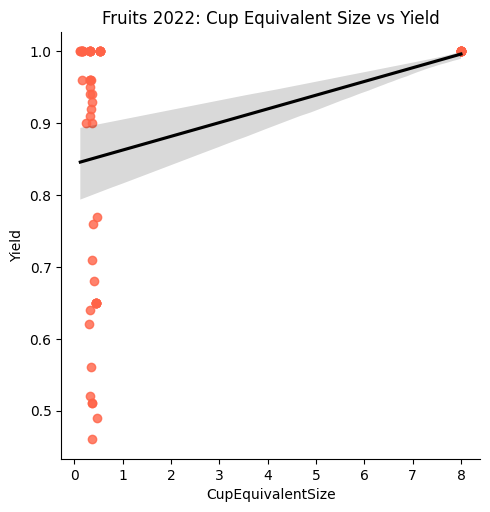

In [7]:
# 2020 - Vegetables
sns.lmplot(data=data_2020[data_2020["Category"] == "Vegetable"],
           x="RetailPrice", y="Yield",
           scatter_kws={'color': 'purple'},
           line_kws={'color': 'black'})
plt.title("Vegetables 2020: Retail Price vs Yield")
plt.show()

# 2020 - Fruits
sns.lmplot(data=data_2020[data_2020["Category"] == "Fruit"],
           x="CupEquivalentSize", y="Yield",
           scatter_kws={'color': 'orange'},
           line_kws={'color': 'black'})
plt.title("Fruits 2020: Cup Equivalent Size vs Yield")
plt.show()

# 2022 - Vegetables
sns.lmplot(data=data_2022[data_2022["Category"] == "Vegetable"],
           x="RetailPrice", y="Yield",
           scatter_kws={'color': 'forestgreen'},
           line_kws={'color': 'black'})
plt.title("Vegetables 2022: Retail Price vs Yield")
plt.show()

# 2022 - Fruits
sns.lmplot(data=data_2022[data_2022["Category"] == "Fruit"],
           x="CupEquivalentSize", y="Yield",
           scatter_kws={'color': 'tomato'},
           line_kws={'color': 'black'})
plt.title("Fruits 2022: Cup Equivalent Size vs Yield")
plt.show()


prepare for association rules

In [8]:
# Bin the price levels
combined_with_gdp["PriceLvl"] = pd.cut(
    combined_with_gdp["CupEquivalentPrice"],
    bins=[0, 0.5, 1, 1.5, 2, float("inf")],
    labels=["Very Low", "Low", "Medium", "High", "Very High"]
)

# Create a list of transactions
transactions = []
for _, row in combined_with_gdp.iterrows():
    transactions.append([
        f"Item={row['Name']}",
        f"Year={row['Year']}",
        f"Category={row['Category']}",
        f"Form={row['Form']}",
        f"PriceLvl={row['PriceLvl']}"
    ])

In [9]:
# Encode transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_trans = pd.DataFrame(te_ary, columns=te.columns_)

# Run Apriori
frequent_itemsets = apriori(df_trans, min_support=0.01, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

# Filter by RHS = "Category=Fruit"
rules_fruit = rules[rules['consequents'].astype(str).str.contains("Category=Fruit")]
rules_veg = rules[rules['consequents'].astype(str).str.contains("Category=Vegetable")]

# Strong vegetable rules with lift > 1.5
strong_veg_rules = rules_veg[rules_veg['lift'] > 1.5]


inspect the rules

In [10]:
# Show top 10 strong vegetable rules
strong_veg_rules.head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
17,(Item=Artichoke),(Category=Vegetable),0.012903,0.6,0.012903,1.0,1.666667,1.0,0.005161,inf,0.405229,0.021505,1.0,0.510753
18,(Item=Asparagus),(Category=Vegetable),0.019355,0.6,0.019355,1.0,1.666667,1.0,0.007742,inf,0.407895,0.032258,1.0,0.516129
19,(Item=Black beans),(Category=Vegetable),0.012903,0.6,0.012903,1.0,1.666667,1.0,0.005161,inf,0.405229,0.021505,1.0,0.510753
20,(Item=Blackeye peas),(Category=Vegetable),0.012903,0.6,0.012903,1.0,1.666667,1.0,0.005161,inf,0.405229,0.021505,1.0,0.510753
21,(Item=Brussels sprouts),(Category=Vegetable),0.012903,0.6,0.012903,1.0,1.666667,1.0,0.005161,inf,0.405229,0.021505,1.0,0.510753
22,(Item=Carrots),(Category=Vegetable),0.012903,0.6,0.012903,1.0,1.666667,1.0,0.005161,inf,0.405229,0.021505,1.0,0.510753
23,(Item=Collard greens),(Category=Vegetable),0.019355,0.6,0.019355,1.0,1.666667,1.0,0.007742,inf,0.407895,0.032258,1.0,0.516129
24,(Item=Corn),(Category=Vegetable),0.019355,0.6,0.019355,1.0,1.666667,1.0,0.007742,inf,0.407895,0.032258,1.0,0.516129
25,(Item=Great northern beans),(Category=Vegetable),0.012903,0.6,0.012903,1.0,1.666667,1.0,0.005161,inf,0.405229,0.021505,1.0,0.510753
26,(Item=Green beans),(Category=Vegetable),0.019355,0.6,0.019355,1.0,1.666667,1.0,0.007742,inf,0.407895,0.032258,1.0,0.516129
